# Nanodegree Engenheiro de Machine Learning
## Aprendizado Supervisionado
## Projeto:Predição de Anormalidades em Voos Utilizando a Previsão do Tempo dos Aeroportos do Brasil
### Projeto Final (Python 3)

## Iniciando

Projeto de conclusão do curso Machine Learning Engineer Nanodegree que tem como objetivo desenvolver um modelo de classificador capaz de prever a ocorrência de cancelamentos ou atrasos nos voos a partir da previsão do tempo (dos aeroportos) e horário do voo. Para treinar o classificador foram utilizados os registros de voos e previsões do tempo de 10 aeroportos de grande importância no Brasil durante o ano de 2018. 

----
## Explorando os dados

Leitura da base de dados tratada, pronta para uso. Os dados foram lidos de um arquivo .csv e armazenado sem um dataframe da biblioteca Pandas.

In [1]:
# Importe as bibliotecas necessárias para o projeto.
from __future__ import division
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Permite a utilização da função display() para DataFrames.

import matplotlib.pyplot as plt  
# desabilita warnings
import warnings
warnings.filterwarnings('ignore')

# Importação da biblioteca de visualização visuals.py
import visuals as vs

# Exibição amigável para notebooks
%matplotlib inline

# Carregando os dados sobre os voos
data = pd.read_csv("Saida_Aero_2.csv", delimiter=";",encoding = "ISO-8859-1")

# Sucesso - Exibindo n primeiros registros
display(data.head(n=3))


,ICAO Empresa Aérea,Número Voo,Código Autorização (DI),Código Tipo Linha,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Chegada Prevista,Chegada Real,...,Td_origem,Hora local_destino,T_destino,Po_destino,U_destino,DD_destino,Ff_destino,N_destino,VV_destino,Td_destino
0,GLO,4939,0,R,SBSP,SBSV,01/01/2018 11:30,01/01/2018 11:50,01/01/2018 13:44,01/01/2018 14:06,...,18.8,01.01.2018 12:00,29.8,758.3,68,1,7,40,20.0,23.2
1,AZU,2400,0,R,SBGR,SBRJ,01/01/2018 06:15,01/01/2018 06:45,01/01/2018 07:15,01/01/2018 07:36,...,18.0,01.01.2018 06:00,25.7,756.4,74,1,1,5,8.0,20.6
2,AZU,2400,0,R,SBGR,SBRJ,03/01/2018 06:15,03/01/2018 05:55,03/01/2018 07:15,03/01/2018 07:12,...,18.4,03.01.2018 06:00,26.3,751.8,86,1,1,60,20.0,23.8


In [2]:
# Remove colunas sem relevância do dataframe
data = data.drop(['ICAO Empresa Aérea','Número Voo','Código Autorização (DI)','Código Tipo Linha','ICAO Aeródromo Origem','ICAO Aeródromo Destino','Partida Prevista','Partida Real','Chegada Prevista','Chegada Real','Situação Voo','Código Justificativa','Hora local_origem','Hora local_destino'], axis=1)
display(data.head(n=5))

,Previsão do Tempo,T_origem,Po_origem,U_origem,DD_origem,Ff_origem,N_origem,VV_origem,Td_origem,T_destino,Po_destino,U_destino,DD_destino,Ff_destino,N_destino,VV_destino,Td_destino
0,NORMAL,25.5,692.5,67,1,6,100,18.0,18.8,29.8,758.3,68,1,7,40,20.0,23.2
1,NORMAL,20.4,691.6,86,1,5,75,18.0,18.0,25.7,756.4,74,1,1,5,8.0,20.6
2,NORMAL,21.2,688.3,84,1,7,100,8.0,18.4,26.3,751.8,86,1,1,60,20.0,23.8
3,NORMAL,17.8,692.8,88,1,2,0,20.0,15.8,23.4,758.2,92,1,2,100,2.5,22.1
4,NORMAL,18.0,693.4,79,1,2,0,20.0,14.2,22.7,760.0,83,1,2,100,17.0,19.7


### Implementação: Explorando os Dados



In [3]:
# TODO: Número total de registros.
n_records = data.shape[0] #numero de linhas

# TODO: Número de registros rotulados como NORMAL
n_flights_normal = data[data['Previsão do Tempo'] == 'NORMAL'].shape[0]

# TODO: O número de registros com remuneração anual até $50,000
n_flights_anormal = data[data['Previsão do Tempo'] == 'ANORMAL'].shape[0]

# TODO: Percentual de voos com problemas
anormal_percent = 100*n_flights_anormal/n_flights_normal

# Exibindo os resultados
print ("Número de registros: {}".format(n_records))
print ("Número de voos sem atrasos/cancelamentos devido a problemas meteorológicos: {}".format(n_flights_normal))
print ("Número de voos com atrasos/cancelamentos devido a problemas meteorológicos: {}".format(n_flights_anormal))
print ("Porcentagem de voos com problemas: {:.2f}%".format(anormal_percent))

Número de registros: 240531
Número de voos sem atrasos/cancelamentos devido a problemas meteorológicos: 238175
Número de voos com atrasos/cancelamentos devido a problemas meteorológicos: 2356
Porcentagem de voos com problemas: 0.99%


----
## Preparando os dados
Antes de que os dados possam ser utilizados como input para algoritmos de machine learning, muitas vezes eles precisam ser tratados, formatados e reestruturados — este processo é conhecido como **pré-processamento**. Felizmente neste conjunto de dados não existem registros inconsistentes para tratamento, porém algumas colunas precisam ser ajustadas. Este pré-processamento pode ajudar muito com o resultado e poder de predição de quase todos os algoritmos de aprendizado.

### Transformando os principais desvios das colunas contínuas
Um conjunto de dados pode conter ao menos uma coluna onde os valores tendem a se próximar para um único número, mas também podem conter registros com o mesmo atributo contendo um valor muito maior ou muito menor do que esta tendência. Algoritmos podem ser sensíveis para estes casos de distribuição de valores e este fator pode prejudicar sua performance se a distribuição não estiver normalizada de maneira adequada. 


Foi gerada uma representação grafica por meio do BOXPLOT que pode ser utilizado para identificar valores que variam muito em relação aos demais.

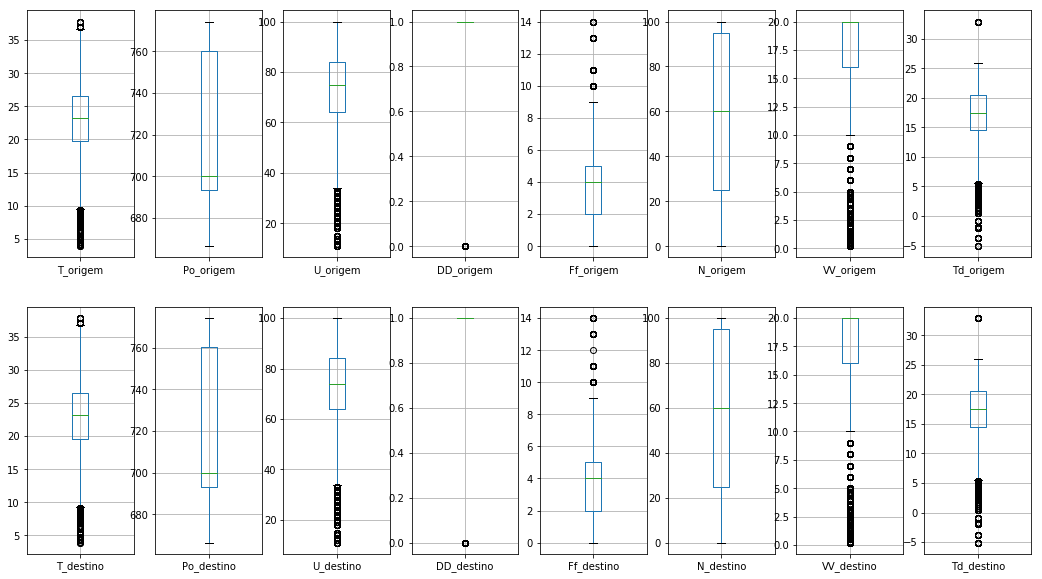

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(18,10)) # create 2x2 array of subplots

data.boxplot(column='T_origem', ax=axes[0,0]) 
data.boxplot(column='Po_origem', ax=axes[0,1]) 
data.boxplot(column='U_origem', ax=axes[0,2]) 
data.boxplot(column='DD_origem', ax=axes[0,3]) 
data.boxplot(column='Ff_origem', ax=axes[0,4]) 
data.boxplot(column='N_origem', ax=axes[0,5]) 
data.boxplot(column='VV_origem', ax=axes[0,6]) 
data.boxplot(column='Td_origem', ax=axes[0,7]) 

data.boxplot(column='T_destino', ax=axes[1,0]) 
data.boxplot(column='Po_destino', ax=axes[1,1]) 
data.boxplot(column='U_destino', ax=axes[1,2]) 
data.boxplot(column='DD_destino', ax=axes[1,3]) 
data.boxplot(column='Ff_destino', ax=axes[1,4]) 
data.boxplot(column='N_destino', ax=axes[1,5]) 
data.boxplot(column='VV_destino', ax=axes[1,6]) 
data.boxplot(column='Td_destino', ax=axes[1,7]) 


# etc.
plt.show()

Como os atributos não apresentam grandes variações não é necessário aplicar a transformação logarítimica neles.



### Estatística Descritiva

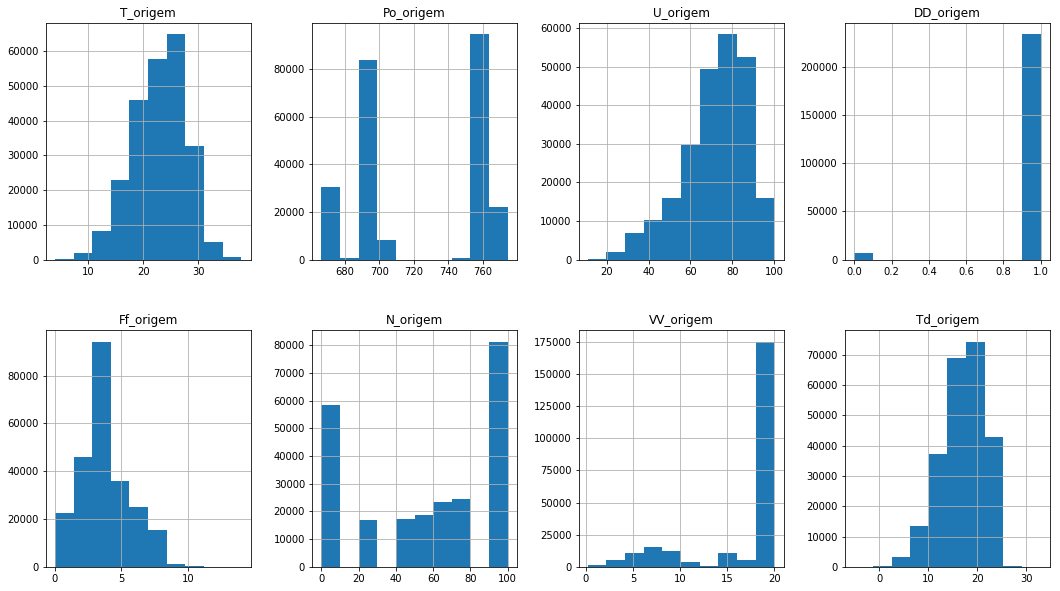

T_origem => MIN: 3.90 | MÁX: 37.80 | MÉDIA: 22.88 | DESV. PADRÃO: 4.79
Po_origem => MIN: 666.40 | MÁX: 774.30 | MÉDIA: 724.05 | DESV. PADRÃO: 36.41
U_origem => MIN: 11.00 | MÁX: 100.00 | MÉDIA: 72.10 | DESV. PADRÃO: 15.51
DD_origem => MIN: 0.00 | MÁX: 1.00 | MÉDIA: 0.97 | DESV. PADRÃO: 0.16
Ff_origem => MIN: 0.00 | MÁX: 14.00 | MÉDIA: 3.70 | DESV. PADRÃO: 1.83
N_origem => MIN: 0.00 | MÁX: 100.00 | MÉDIA: 55.44 | DESV. PADRÃO: 38.13
VV_origem => MIN: 0.20 | MÁX: 20.00 | MÉDIA: 17.14 | DESV. PADRÃO: 5.20
Td_origem => MIN: -5.10 | MÁX: 32.90 | MÉDIA: 17.11 | DESV. PADRÃO: 4.30

T_destino => MIN: 3.90 | MÁX: 37.80 | MÉDIA: 22.88 | DESV. PADRÃO: 4.82
Po_destino => MIN: 666.40 | MÁX: 774.30 | MÉDIA: 724.11 | DESV. PADRÃO: 36.42
U_destino => MIN: 11.00 | MÁX: 100.00 | MÉDIA: 72.14 | DESV. PADRÃO: 15.44
DD_destino => MIN: 0.00 | MÁX: 1.00 | MÉDIA: 0.97 | DESV. PADRÃO: 0.16
Ff_destino => MIN: 0.00 | MÁX: 14.00 | MÉDIA: 3.75 | DESV. PADRÃO: 1.84
N_destino => MIN: 0.00 | MÁX: 100.00 | MÉDIA: 55.4

In [5]:



fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18,10)) # create 2x2 array of subplots

data.hist(column='T_origem', ax=axes[0,0]) 
data.hist(column='Po_origem', ax=axes[0,1]) 
data.hist(column='U_origem', ax=axes[0,2]) 
data.hist(column='DD_origem', ax=axes[0,3]) 
data.hist(column='Ff_origem', ax=axes[1,0]) 
data.hist(column='N_origem', ax=axes[1,1]) 
data.hist(column='VV_origem', ax=axes[1,2]) 
data.hist(column='Td_origem', ax=axes[1,3]) 


# etc.
plt.show()


print("T_origem => MIN: {:.2f} | MÁX: {:.2f} | MÉDIA: {:.2f} | DESV. PADRÃO: {:.2f}".format(data['T_origem'].min(),data['T_origem'].max(),data['T_origem'].mean(),data['T_origem'].std()))
print("Po_origem => MIN: {:.2f} | MÁX: {:.2f} | MÉDIA: {:.2f} | DESV. PADRÃO: {:.2f}".format(data['Po_origem'].min(),data['Po_origem'].max(),data['Po_origem'].mean(),data['Po_origem'].std()))
print("U_origem => MIN: {:.2f} | MÁX: {:.2f} | MÉDIA: {:.2f} | DESV. PADRÃO: {:.2f}".format(data['U_origem'].min(),data['U_origem'].max(),data['U_origem'].mean(),data['U_origem'].std()))
print("DD_origem => MIN: {:.2f} | MÁX: {:.2f} | MÉDIA: {:.2f} | DESV. PADRÃO: {:.2f}".format(data['DD_origem'].min(),data['DD_origem'].max(),data['DD_origem'].mean(),data['DD_origem'].std()))
print("Ff_origem => MIN: {:.2f} | MÁX: {:.2f} | MÉDIA: {:.2f} | DESV. PADRÃO: {:.2f}".format(data['Ff_origem'].min(),data['Ff_origem'].max(),data['Ff_origem'].mean(),data['Ff_origem'].std()))
print("N_origem => MIN: {:.2f} | MÁX: {:.2f} | MÉDIA: {:.2f} | DESV. PADRÃO: {:.2f}".format(data['N_origem'].min(),data['N_origem'].max(),data['N_origem'].mean(),data['N_origem'].std()))
print("VV_origem => MIN: {:.2f} | MÁX: {:.2f} | MÉDIA: {:.2f} | DESV. PADRÃO: {:.2f}".format(data['VV_origem'].min(),data['VV_origem'].max(),data['VV_origem'].mean(),data['VV_origem'].std()))
print("Td_origem => MIN: {:.2f} | MÁX: {:.2f} | MÉDIA: {:.2f} | DESV. PADRÃO: {:.2f}".format(data['Td_origem'].min(),data['Td_origem'].max(),data['Td_origem'].mean(),data['Td_origem'].std()))

print()

print("T_destino => MIN: {:.2f} | MÁX: {:.2f} | MÉDIA: {:.2f} | DESV. PADRÃO: {:.2f}".format(data['T_destino'].min(),data['T_destino'].max(),data['T_destino'].mean(),data['T_destino'].std()))
print("Po_destino => MIN: {:.2f} | MÁX: {:.2f} | MÉDIA: {:.2f} | DESV. PADRÃO: {:.2f}".format(data['Po_destino'].min(),data['Po_destino'].max(),data['Po_destino'].mean(),data['Po_destino'].std()))
print("U_destino => MIN: {:.2f} | MÁX: {:.2f} | MÉDIA: {:.2f} | DESV. PADRÃO: {:.2f}".format(data['U_destino'].min(),data['U_destino'].max(),data['U_destino'].mean(),data['U_destino'].std()))
print("DD_destino => MIN: {:.2f} | MÁX: {:.2f} | MÉDIA: {:.2f} | DESV. PADRÃO: {:.2f}".format(data['DD_destino'].min(),data['DD_destino'].max(),data['DD_destino'].mean(),data['DD_destino'].std()))
print("Ff_destino => MIN: {:.2f} | MÁX: {:.2f} | MÉDIA: {:.2f} | DESV. PADRÃO: {:.2f}".format(data['Ff_destino'].min(),data['Ff_destino'].max(),data['Ff_destino'].mean(),data['Ff_destino'].std()))
print("N_destino => MIN: {:.2f} | MÁX: {:.2f} | MÉDIA: {:.2f} | DESV. PADRÃO: {:.2f}".format(data['N_destino'].min(),data['N_destino'].max(),data['N_destino'].mean(),data['N_destino'].std()))
print("VV_destino => MIN: {:.2f} | MÁX: {:.2f} | MÉDIA: {:.2f} | DESV. PADRÃO: {:.2f}".format(data['VV_destino'].min(),data['VV_destino'].max(),data['VV_destino'].mean(),data['VV_destino'].std()))
print("Td_destino => MIN: {:.2f} | MÁX: {:.2f} | MÉDIA: {:.2f} | DESV. PADRÃO: {:.2f}".format(data['Td_destino'].min(),data['Td_destino'].max(),data['Td_destino'].mean(),data['Td_destino'].std()))




### Normalizando atributos numéricos
Além das transformações em atributos distorcidos, é uma boa prática comum realizar algum tipo de adaptação de escala nos atributos numéricos. Ajustar a escala nos dados não modifica o formato da distribuição de cada coluna ; no entanto, a normalização garante que cada atributo será tratado com o mesmo peso durante a aplicação de aprendizado supervisionado. Note que uma vez aplicada a escala, a observação dos dados não terá o significado original, como exemplificado abaixo.



In [6]:
# Importando sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Inicializando um aplicador de escala e aplicando em seguida aos atributos
scaler = MinMaxScaler() # default=(0, 1)


param_origem = ['T_origem','Po_origem','U_origem','DD_origem','Ff_origem','N_origem','VV_origem','Td_origem']
param_destino = ['T_destino','Po_destino','U_destino','DD_destino','Ff_destino','N_destino','VV_destino','Td_destino']

params = param_origem + param_destino
#print(params)
data[params] = scaler.fit_transform(data[params])

# Exibindo um exemplo de registro com a escala aplicada
display(data.head(n=3))

,Previsão do Tempo,T_origem,Po_origem,U_origem,DD_origem,Ff_origem,N_origem,VV_origem,Td_origem,T_destino,Po_destino,U_destino,DD_destino,Ff_destino,N_destino,VV_destino,Td_destino
0,NORMAL,0.637168,0.241891,0.629213,1.0,0.428571,1.00,0.898990,0.628947,0.764012,0.851715,0.640449,1.0,0.500000,0.40,1.000000,0.744737
1,NORMAL,0.486726,0.233550,0.842697,1.0,0.357143,0.75,0.898990,0.607895,0.643068,0.834106,0.707865,1.0,0.071429,0.05,0.393939,0.676316
2,NORMAL,0.510324,0.202966,0.820225,1.0,0.500000,1.00,0.393939,0.618421,0.660767,0.791474,0.842697,1.0,0.071429,0.60,1.000000,0.760526


### Implementação: Pré-processamento dos dados

Conversão dos valores das colunas para o formato numérico. 

In [7]:

data = data.replace(['NORMAL'], 0)   
data = data.replace(['ANORMAL'], 1)

# balanceamento dos dados
df1 = data[data['Previsão do Tempo']==1]
df0 = data[data['Previsão do Tempo']==0].sample(frac=0.01, random_state=8)
df = pd.concat([df1,df0])

# Número total de registros.
n_records = df.shape[0] #numero de linhas
# Número de registros rotulados como NORMAL
n_flights_normal = df[df['Previsão do Tempo'] == 0].shape[0]
# Número de registros rotulados como ANORMAL
n_flights_anormal = df[df['Previsão do Tempo'] == 1].shape[0]

# TODO: Percentual de voos com problemas
anormal_percent = 100*n_flights_anormal/(n_flights_normal+n_flights_anormal)

# Exibindo os resultados
print ("Número de registros: {}".format(n_records))
print ("Número de voos sem atrasos/cancelamentos devido a problemas meteorológicos: {}".format(n_flights_normal))
print ("Número de voos com atrasos/cancelamentos devido a problemas meteorológicos: {}".format(n_flights_anormal))
print ("Porcentagem de voos com problemas: {:.2f}%".format(anormal_percent))


display(df.head(n=10))

Número de registros: 4738
Número de voos sem atrasos/cancelamentos devido a problemas meteorológicos: 2382
Número de voos com atrasos/cancelamentos devido a problemas meteorológicos: 2356
Porcentagem de voos com problemas: 49.73%


,Previsão do Tempo,T_origem,Po_origem,U_origem,DD_origem,Ff_origem,N_origem,VV_origem,Td_origem,T_destino,Po_destino,U_destino,DD_destino,Ff_destino,N_destino,VV_destino,Td_destino
49,1,0.719764,0.909175,0.584270,1.0,0.214286,0.25,1.000000,0.673684,0.557522,0.289157,0.696629,1.0,0.285714,0.00,1.000000,0.597368
94,1,0.775811,0.857275,0.337079,1.0,0.285714,0.00,1.000000,0.539474,0.651917,0.863763,0.752809,1.0,0.214286,1.00,0.393939,0.710526
262,1,0.522124,0.268767,0.775281,1.0,0.142857,0.95,1.000000,0.605263,0.595870,0.863763,0.797753,1.0,0.357143,0.75,1.000000,0.684211
264,1,0.545723,0.251158,0.651685,1.0,0.142857,0.95,1.000000,0.568421,0.613569,0.805375,0.910112,1.0,0.214286,0.95,1.000000,0.747368
269,1,0.522124,0.264133,0.797753,1.0,0.142857,0.95,0.747475,0.615789,0.584071,0.877665,0.719101,1.0,0.500000,0.00,1.000000,0.631579
491,1,0.660767,0.882298,0.584270,1.0,0.214286,0.60,1.000000,0.628947,0.557522,0.279889,0.820225,1.0,0.285714,0.95,0.747475,0.660526
913,1,0.471976,0.229842,0.865169,1.0,0.428571,1.00,0.141414,0.605263,0.569322,0.848934,0.651685,1.0,0.214286,0.40,1.000000,0.584211
992,1,0.743363,0.231696,0.393258,1.0,0.428571,0.50,1.000000,0.560526,0.790560,0.806302,0.584270,1.0,0.214286,0.75,1.000000,0.734211
1170,1,0.445428,0.275255,0.887640,1.0,0.214286,1.00,0.343434,0.589474,0.584071,0.886006,0.876404,1.0,0.142857,1.00,0.393939,0.707895
1235,1,0.566372,0.248378,0.696629,1.0,0.500000,1.00,1.000000,0.605263,0.690265,0.843373,0.696629,1.0,0.357143,1.00,0.595960,0.715789


### Embaralhar e dividir os dados
Todas as _variáveis de categoria_ foram convertidas em atributos numéricos e todos os atributos numéricos foram normalizados. Agora, dividiremos os dados entre conjuntos de treinamento e de teste. 80% dos dados serão utilizados para treinamento e 20% para teste.



In [8]:
# Importar train_test_split
from sklearn.model_selection import train_test_split



# Dividir os 'atributos' e 'income' entre conjuntos de treinamento e de testes.

dados = df.iloc[:,1:]
rotulos = df.iloc[:,0]
# utilizei stratified sampling para equilibrar o número de elementos de cada classe nos conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(dados, 
                                                    rotulos, 
                                                    stratify=rotulos,
                                                    test_size = 0.2, 
                                                    random_state = 4)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))
#soma = 0
#for i in range(len(y_train)):
#    if y_train.iloc[i] == 1:
#        soma +=1
#print(soma)        

Training set has 3790 samples.
Testing set has 948 samples.


----
## Avaliando a performance do modelo
Nesta seção nós investigaremos quatro algoritmos diferentes e determinaremos qual deles é melhor para a modelagem dos dados. 

In [9]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end -start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, average = 'binary', beta = 1)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] =  fbeta_score(y_test, predictions_test, average = 'binary', beta = 1)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

SVC trained on 3790 samples.
AdaBoostClassifier trained on 3790 samples.
LogisticRegression trained on 3790 samples.
RandomForestClassifier trained on 3790 samples.
train_time =  [0.484236478805542, 0.031243324279785156, 0.27402305603027344, 0.0624852180480957]
pred_time =  [0.10934758186340332, 0.0, 0.015595436096191406, 0.0]
acc_train =  [0.6, 0.6133333333333333, 0.6666666666666666, 0.9566666666666667]
acc_test =  [0.5928270042194093, 0.5991561181434599, 0.629746835443038, 0.6687763713080169]
f_train =  [0.49152542372881364, 0.5735294117647058, 0.6551724137931035, 0.9550173010380623]
f_test =  [0.4741144414168937, 0.5529411764705882, 0.6229860365198711, 0.654945054945055]


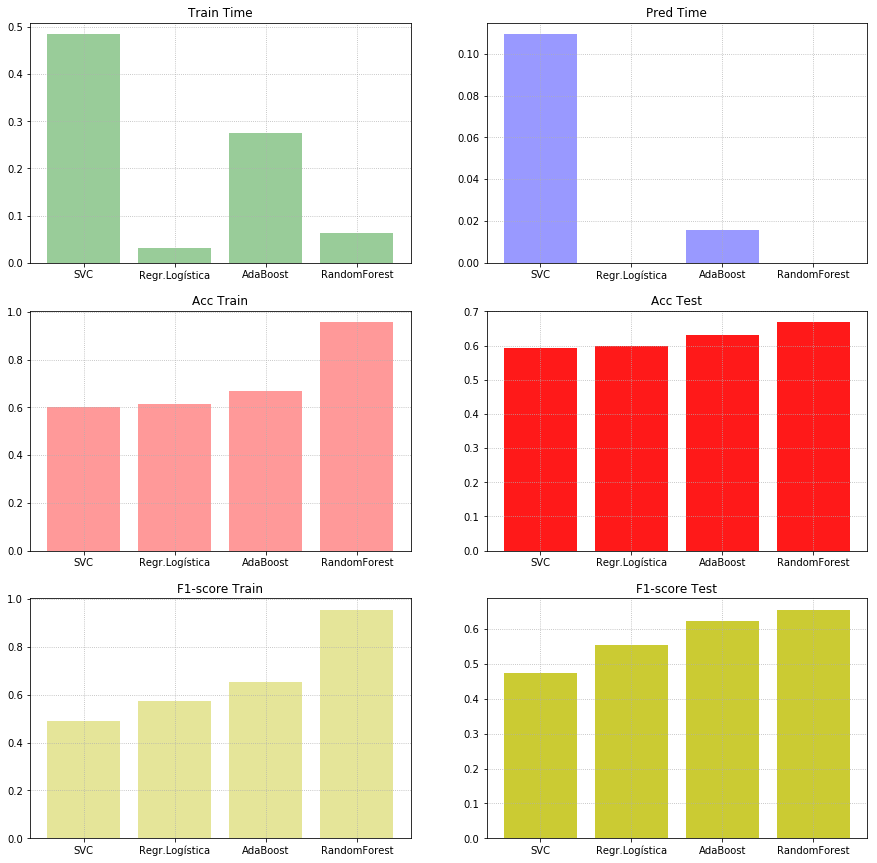

In [10]:
# TODO: Importe os três modelos de aprendizado supervisionado da sklearn
#from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
#Nome do classificador


classif_1 = "SVC" 
classif_2 = "LogisticRegression" 
classif_3 = "AdaBoostClassifier" 
classif_4 = "RandomForestClassifier"


# TODO: Inicialize os três modelos
clf_A = SVC(random_state = 2)
clf_B = AdaBoostClassifier(random_state = 2)
clf_C = LogisticRegression(random_state = 2)
clf_D = RandomForestClassifier(random_state = 2)


samples_100 = int(len(y_train))



# Colete os resultados dos algoritmos de aprendizado
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
#vs.evaluate(results, accuracy, fscore)

# Plota resultados 

classificadores = ["SVC", "Regr.Logística", "AdaBoost","RandomForest"]
train_time = []
pred_time = []
acc_train = []
acc_test = []
f_train = []
f_test = []

for i in [classif_1, classif_2, classif_3, classif_4]: 
    for j in results[i][0].items(): 
        if j[0] == "train_time":
            train_time += [j[1]]
        if j[0] == "pred_time":
            pred_time += [j[1]]
        if j[0] == "acc_train":
            acc_train += [j[1]]
        if j[0] == "acc_test":
            acc_test += [j[1]]
        if j[0] == "f_train":
            f_train += [j[1]]
        if j[0] == "f_test":
            f_test += [j[1]]

print("train_time = ", train_time) 
print("pred_time = ", pred_time)
print("acc_train = ", acc_train)                 
print("acc_test = ", acc_test)            
print("f_train = ", f_train)                 
print("f_test = ", f_test)                
            
fig, axs = plt.subplots(3, 2, figsize=(15,15))

axs[0,0].bar(classificadores, train_time,  alpha=0.4, color='g')
axs[0,0].set_title('Train Time')
axs[0,0].grid(linestyle='dotted')

axs[0,1].bar(classificadores, pred_time,  alpha=0.4, color='b')
axs[0,1].set_title('Pred Time')
axs[0,1].grid(linestyle='dotted')

axs[1,0].bar(classificadores, acc_train,  alpha=0.4, color='r')
axs[1,0].set_title('Acc Train')
axs[1,0].grid(linestyle='dotted')

axs[1,1].bar(classificadores, acc_test,  alpha=0.9, color='r')
axs[1,1].set_title('Acc Test')
axs[1,1].grid(linestyle='dotted')

axs[2,0].bar(classificadores, f_train,  alpha=0.4, color='y')
axs[2,0].set_title('F1-score Train')
axs[2,0].grid(linestyle='dotted')

axs[2,1].bar(classificadores, f_test,  alpha=0.8, color='y')
axs[2,1].set_title('F1-score Test')
axs[2,1].grid(linestyle='dotted')

#axs[1, 0].scatter(data[0], data[1])
#axs[0, 1].plot(data[0], data[1])
#axs[1, 1].hist2d(data[0], data[1])

plt.rcParams.update({'font.size': 14})
plt.show()

----
## Melhorando os resultados
Processo de otimização do classificador escolhido através do método de GridSearch.

In [11]:

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint


clf = RandomForestClassifier(random_state=42)

parameters = { 
    'n_estimators': [10,20,30,50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [8,9,10,12,15,20],
    'criterion' :['gini', 'entropy']
    
}

#Criar um objeto fbeta_score utilizando make_scorer()
scorer = make_scorer(fbeta_score, beta = 2)

#Realizar uma busca grid no classificador utilizando o 'scorer' como o método de score no GridSearchCV() 
# valor default de cross-validation é cv= 3
grid_obj = GridSearchCV(clf, parameters, scoring=scorer,verbose=3)

#Adequar o objeto da busca grid como os dados para treinamento e encontrar os parâmetros ótimos utilizando fit() 
grid_fit = grid_obj.fit(X_train, y_train)

# Recuperar o estimador
best_clf = grid_fit.best_estimator_

# Realizar predições utilizando o modelo não otimizado e modelar
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Reportar os scores de antes e de depois
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 2)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 2)))

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=10, score=0.6035598705501618, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=10, score=0.6085258704848682, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=10, score=0.5580939947780678, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=20 .
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=20, score=0.6177231565329884, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=20 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=20, score=0.6060111074812152, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=20 .
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=20, score=0.595703125, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=30 .
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=30, score=0.6042345276872965, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=30 .
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=30, score=0.5977726826072716, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=30 .
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=30, score=0.5794484569927774, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=50 .
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=50, score=0.6037000973709835, 

[CV]  criterion=gini, max_depth=9, max_features=sqrt, n_estimators=20, score=0.5951219512195122, total=   0.0s
[CV] criterion=gini, max_depth=9, max_features=sqrt, n_estimators=20 .
[CV]  criterion=gini, max_depth=9, max_features=sqrt, n_estimators=20, score=0.5808656036446469, total=   0.0s
[CV] criterion=gini, max_depth=9, max_features=sqrt, n_estimators=30 .
[CV]  criterion=gini, max_depth=9, max_features=sqrt, n_estimators=30, score=0.6045910119624959, total=   0.0s
[CV] criterion=gini, max_depth=9, max_features=sqrt, n_estimators=30 .
[CV]  criterion=gini, max_depth=9, max_features=sqrt, n_estimators=30, score=0.595703125, total=   0.0s
[CV] criterion=gini, max_depth=9, max_features=sqrt, n_estimators=30 .
[CV]  criterion=gini, max_depth=9, max_features=sqrt, n_estimators=30, score=0.5870841487279843, total=   0.0s
[CV] criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50 .
[CV]  criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50, score=0.6169041450777201, 

[CV]  criterion=gini, max_depth=10, max_features=log2, n_estimators=20, score=0.6225806451612903, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=log2, n_estimators=20 
[CV]  criterion=gini, max_depth=10, max_features=log2, n_estimators=20, score=0.6102680012915724, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=log2, n_estimators=30 
[CV]  criterion=gini, max_depth=10, max_features=log2, n_estimators=30, score=0.6435006435006434, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=log2, n_estimators=30 
[CV]  criterion=gini, max_depth=10, max_features=log2, n_estimators=30, score=0.6187236799481697, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=log2, n_estimators=30 
[CV]  criterion=gini, max_depth=10, max_features=log2, n_estimators=30, score=0.5963600909977251, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=log2, n_estimators=50 
[CV]  criterion=gini, max_depth=10, max_features=log2, n_estimators=50, score=0.63733

[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=20, score=0.6294042280589366, total=   0.0s
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=20 
[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=20, score=0.6298324742268042, total=   0.0s
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=20 
[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=20, score=0.6237879767291532, total=   0.0s
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=30 
[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=30, score=0.6486833654463712, total=   0.0s
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=30 
[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=30, score=0.6435963777490298, total=   0.0s
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=30 
[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=30, score=0.62923

[CV]  criterion=gini, max_depth=20, max_features=sqrt, n_estimators=20, score=0.6208, total=   0.0s
[CV] criterion=gini, max_depth=20, max_features=sqrt, n_estimators=20 
[CV]  criterion=gini, max_depth=20, max_features=sqrt, n_estimators=20, score=0.6181229773462783, total=   0.0s
[CV] criterion=gini, max_depth=20, max_features=sqrt, n_estimators=20 
[CV]  criterion=gini, max_depth=20, max_features=sqrt, n_estimators=20, score=0.6252014179825974, total=   0.0s
[CV] criterion=gini, max_depth=20, max_features=sqrt, n_estimators=30 
[CV]  criterion=gini, max_depth=20, max_features=sqrt, n_estimators=30, score=0.6326073030108904, total=   0.0s
[CV] criterion=gini, max_depth=20, max_features=sqrt, n_estimators=30 
[CV]  criterion=gini, max_depth=20, max_features=sqrt, n_estimators=30, score=0.635048231511254, total=   0.0s
[CV] criterion=gini, max_depth=20, max_features=sqrt, n_estimators=30 
[CV]  criterion=gini, max_depth=20, max_features=sqrt, n_estimators=30, score=0.6276218134882221, 

[CV] criterion=entropy, max_depth=8, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=8, max_features=log2, n_estimators=10, score=0.6034204582123265, total=   0.0s
[CV] criterion=entropy, max_depth=8, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=8, max_features=log2, n_estimators=10, score=0.6046814044213263, total=   0.0s
[CV] criterion=entropy, max_depth=8, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=8, max_features=log2, n_estimators=10, score=0.5621107833497214, total=   0.0s
[CV] criterion=entropy, max_depth=8, max_features=log2, n_estimators=20 
[CV]  criterion=entropy, max_depth=8, max_features=log2, n_estimators=20, score=0.5877564311299251, total=   0.0s
[CV] criterion=entropy, max_depth=8, max_features=log2, n_estimators=20 
[CV]  criterion=entropy, max_depth=8, max_features=log2, n_estimators=20, score=0.5855263157894737, total=   0.0s
[CV] criterion=entropy, max_depth=8, max_features=log2, n_estimat

[CV]  criterion=entropy, max_depth=9, max_features=log2, n_estimators=30, score=0.5788783207609052, total=   0.0s
[CV] criterion=entropy, max_depth=9, max_features=log2, n_estimators=50 
[CV]  criterion=entropy, max_depth=9, max_features=log2, n_estimators=50, score=0.5958971019211983, total=   0.1s
[CV] criterion=entropy, max_depth=9, max_features=log2, n_estimators=50 
[CV]  criterion=entropy, max_depth=9, max_features=log2, n_estimators=50, score=0.610313315926893, total=   0.1s
[CV] criterion=entropy, max_depth=9, max_features=log2, n_estimators=50 
[CV]  criterion=entropy, max_depth=9, max_features=log2, n_estimators=50, score=0.5963302752293578, total=   0.1s
[CV] criterion=entropy, max_depth=10, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=10, max_features=auto, n_estimators=10, score=0.6074313408723748, total=   0.0s
[CV] criterion=entropy, max_depth=10, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=10, max_features=auto, n_est

[CV]  criterion=entropy, max_depth=12, max_features=auto, n_estimators=20, score=0.6029173419773095, total=   0.0s
[CV] criterion=entropy, max_depth=12, max_features=auto, n_estimators=30 
[CV]  criterion=entropy, max_depth=12, max_features=auto, n_estimators=30, score=0.6001294079585894, total=   0.0s
[CV] criterion=entropy, max_depth=12, max_features=auto, n_estimators=30 
[CV]  criterion=entropy, max_depth=12, max_features=auto, n_estimators=30, score=0.6338939197930142, total=   0.0s
[CV] criterion=entropy, max_depth=12, max_features=auto, n_estimators=30 
[CV]  criterion=entropy, max_depth=12, max_features=auto, n_estimators=30, score=0.6138645934564303, total=   0.0s
[CV] criterion=entropy, max_depth=12, max_features=auto, n_estimators=50 
[CV]  criterion=entropy, max_depth=12, max_features=auto, n_estimators=50, score=0.632258064516129, total=   0.1s
[CV] criterion=entropy, max_depth=12, max_features=auto, n_estimators=50 
[CV]  criterion=entropy, max_depth=12, max_features=auto

[CV]  criterion=entropy, max_depth=15, max_features=sqrt, n_estimators=20, score=0.6429483088704532, total=   0.0s
[CV] criterion=entropy, max_depth=15, max_features=sqrt, n_estimators=20 
[CV]  criterion=entropy, max_depth=15, max_features=sqrt, n_estimators=20, score=0.6548956661316212, total=   0.0s
[CV] criterion=entropy, max_depth=15, max_features=sqrt, n_estimators=20 
[CV]  criterion=entropy, max_depth=15, max_features=sqrt, n_estimators=20, score=0.6179230022646391, total=   0.0s
[CV] criterion=entropy, max_depth=15, max_features=sqrt, n_estimators=30 
[CV]  criterion=entropy, max_depth=15, max_features=sqrt, n_estimators=30, score=0.6414368184733804, total=   0.0s
[CV] criterion=entropy, max_depth=15, max_features=sqrt, n_estimators=30 
[CV]  criterion=entropy, max_depth=15, max_features=sqrt, n_estimators=30, score=0.648596321393998, total=   0.1s
[CV] criterion=entropy, max_depth=15, max_features=sqrt, n_estimators=30 
[CV]  criterion=entropy, max_depth=15, max_features=sqrt

[CV]  criterion=entropy, max_depth=20, max_features=sqrt, n_estimators=50, score=0.6142625607779579, total=   0.2s
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=20, max_features=log2, n_estimators=10, score=0.5830903790087464, total=   0.0s
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=20, max_features=log2, n_estimators=10, score=0.6039507772020726, total=   0.0s
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=20, max_features=log2, n_estimators=10, score=0.5901426718547341, total=   0.0s
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=20 
[CV]  criterion=entropy, max_depth=20, max_features=log2, n_estimators=20, score=0.630788885340147, total=   0.0s
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=20 
[CV]  criterion=entropy, max_depth=20, max_features=log2

[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:   52.8s finished


Unoptimized model
------
Accuracy score on testing data: 0.6603
F-score on testing data: 0.6133

Optimized Model
------
Final accuracy score on the testing data: 0.6857
Final F-score on the testing data: 0.6459


### Análise dos dados com a matriz de Confusão

[[352 125]
 [173 298]]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


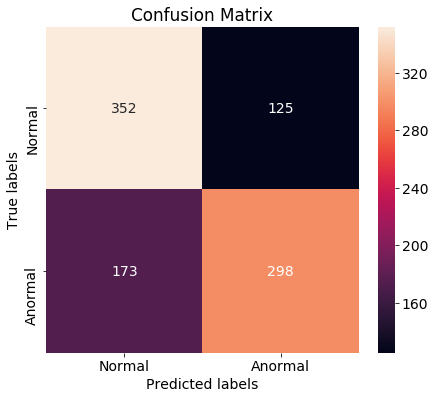

In [12]:
#print(best_clf)
from sklearn.metrics import confusion_matrix
import seaborn as sns

#print(y_test)
cm= confusion_matrix(y_test, best_predictions)

print (cm)
fig, ax= plt.subplots(1,1,figsize=(7,6))
sns.heatmap(cm, annot=True,fmt='.0f', ax = ax); #annot=True to annotate cells

#print(np.sum(best_predictions))
print(best_clf)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal', 'Anormal']); ax.yaxis.set_ticklabels(['Normal', 'Anormal']);
plt.rcParams.update({'font.size': 18})

### Curva ROC

              precision    recall  f1-score   support

           0       0.67      0.74      0.70       477
           1       0.70      0.63      0.67       471

   micro avg       0.69      0.69      0.69       948
   macro avg       0.69      0.69      0.68       948
weighted avg       0.69      0.69      0.68       948



<Figure size 432x288 with 0 Axes>

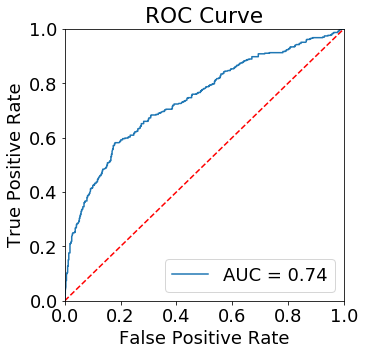

In [13]:
from sklearn import metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, best_predictions))

#VERIFICAR 
preds = best_clf.predict_proba(X_test)[:,1] 


# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()
plt.figure(figsize=(5,5))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.0,1.0])
plt.ylim([-0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.rcParams.update({'font.size': 12})
plt.show()


## Comparação a um Benchmark

Para avaliar o quão bom é o modelo, foi definido um benchmark utilizando um modelo de um classificador simples, disponível na biblioteca **Scikit-learn** . Espera-se obter uma performance superior do modelo de florestas aleatórias em relação ao benchmark.

In [14]:
from sklearn.dummy import DummyClassifier

for strategy in ['stratified', 'most_frequent', 'prior', 'uniform']:
    dummy = DummyClassifier(strategy=strategy, random_state = 8)
    dummy.fit(X_train, y_train)
    
    dummy_predicted = dummy.predict(X_test)
    # acurácia
    dummy_acc = accuracy_score(y_test, dummy_predicted)
        
    # fbeta-score (beta = 2)
    dummy_fscore = fbeta_score(y_test, dummy_predicted, average = 'binary', beta = 2)
       
    print("Estratégia do Classificador: {} \ Acurácia: {:.4f} \ fbeta-score(beta=2): {:.4f}".format(strategy,dummy_acc,dummy_fscore))    
    
    if strategy == 'stratified':
        print(confusion_matrix(y_test, dummy_predicted))    
     

Estratégia do Classificador: stratified \ Acurácia: 0.5190 \ fbeta-score(beta=2): 0.5243
[[244 233]
 [223 248]]
Estratégia do Classificador: most_frequent \ Acurácia: 0.5032 \ fbeta-score(beta=2): 0.0000
Estratégia do Classificador: prior \ Acurácia: 0.5032 \ fbeta-score(beta=2): 0.0000
Estratégia do Classificador: uniform \ Acurácia: 0.4863 \ fbeta-score(beta=2): 0.4958


## Desempenho com novos dados
Com o modelo de classificador criado foi realizado teste para verificar o comportamento do modelo na classificação de novos dados. Foram obtidos informações de voo de quatro aeroportos.

Número de registros: 566
Número de voos sem atrasos/cancelamentos devido a problemas meteorológicos: 307
Número de voos com atrasos/cancelamentos devido a problemas meteorológicos: 259
Final accuracy score on the testing data: 0.6413
Final F-score on the testing data: 0.5242


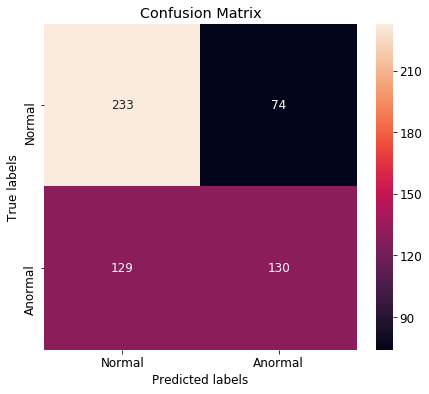

In [15]:
# Carregando novos dados sobre os voos
data_val = pd.read_csv("Saida_Aero_Val.csv", delimiter=";",encoding = "ISO-8859-1")
 # normaliza os dados
data_val[params] = scaler.transform(data_val[params])
# Remove colunas sem relevância do dataframe
data_val = data_val.drop(['ICAO Empresa Aérea','Número Voo','Código Autorização (DI)','Código Tipo Linha','ICAO Aeródromo Origem','ICAO Aeródromo Destino','Partida Prevista','Partida Real','Chegada Prevista','Chegada Real','Situação Voo','Código Justificativa','Hora local_origem','Hora local_destino'], axis=1)

# Ajuste nos dados
data_val = data_val.replace(['NORMAL'], 0)   
data_val = data_val.replace(['ANORMAL'], 1)


df1_val = data_val[data_val['Previsão do Tempo']==1]
df0_val = data_val[data_val['Previsão do Tempo']==0].sample(frac=0.02, random_state=8)
df_val = pd.concat([df1_val,df0_val])

# Número total de registros.
n_records = df_val.shape[0] #numero de linhas
# Número de registros rotulados como NORMAL
n_flights_normal = df_val[df_val['Previsão do Tempo'] == 0].shape[0]
# Número de registros rotulados como ANORMAL
n_flights_anormal = df_val[df_val['Previsão do Tempo'] == 1].shape[0]

# TODO: Percentual de voos com problemas
anormal_percent = 100*n_flights_anormal/(n_flights_normal+n_flights_anormal)

# Exibindo os resultados
print ("Número de registros: {}".format(n_records))
print ("Número de voos sem atrasos/cancelamentos devido a problemas meteorológicos: {}".format(n_flights_normal))
print ("Número de voos com atrasos/cancelamentos devido a problemas meteorológicos: {}".format(n_flights_anormal))

# separa rótulos dos atributos
X_val = df_val.iloc[:,1:]
y_val = df_val.iloc[:,0]

# uso do classificador
predicted_val = best_clf.predict(X_val)
# resultados
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_val, predicted_val)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_val, predicted_val, beta = 2)))

# Cria matriz de confusão
cm= confusion_matrix(y_val, predicted_val)


fig, ax= plt.subplots(1,1,figsize=(7,6))
sns.heatmap(cm, annot=True,fmt='.0f', ax = ax); #annot=True to annotate cells


# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal', 'Anormal']); ax.yaxis.set_ticklabels(['Normal', 'Anormal']);
plt.rcParams.update({'font.size': 18})

----
## Importância dos atributos
### Observação da Relevância dos Atributos

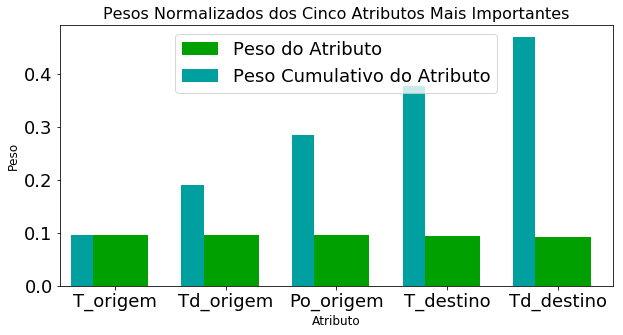

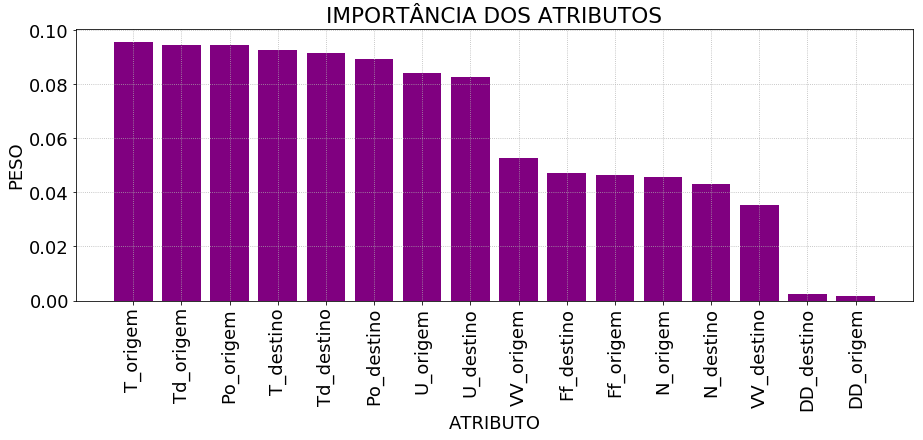

['T_origem' 'Td_origem' 'Po_origem' 'T_destino' 'Td_destino' 'Po_destino'
 'U_origem' 'U_destino' 'VV_origem' 'Ff_destino' 'Ff_origem' 'N_origem'
 'N_destino' 'VV_destino' 'DD_destino' 'DD_origem']
[0.09577788 0.0946835  0.09454887 0.09285654 0.09143551 0.08946238
 0.08413374 0.08263115 0.05257091 0.04736    0.04659243 0.04575539
 0.0430085  0.03520071 0.00228597 0.00169651]


In [16]:

#Extrair a importância dos atributos utilizando .feature_importances_ 
importances = best_clf.feature_importances_

# Plota 5 atributos mais relevantes
vs.feature_plot(importances, X_train, y_train)

# Plota a relevância de todos os atributos
indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:]]
values = importances[indices][:]

plt.figure(figsize=(15,5))
plt.title('IMPORTÂNCIA DOS ATRIBUTOS')
plt.bar(columns, values, color='purple')

plt.ylabel('PESO')
plt.xlabel('ATRIBUTO')
plt.xticks(rotation=90)
plt.grid(linestyle='dotted')
plt.rcParams.update({'font.size': 12})

plt.show()


print(columns)
print(values)


## Desempenho do Modelo Com Menos Atributos

### Criação de novo modelo

Foi criado um novo modelo de classificador que não utiliza o atributos DD_destino e DD_origem

In [17]:
# DADOS DOS 10 AEROPORTOS
# Remove colunas sem relevância do dataframe
df = df.drop(['DD_destino','DD_origem'], axis=1)
# Preparação dos dados
dados = df.iloc[:,1:]
rotulos = df.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(dados, rotulos, stratify=rotulos,test_size = 0.2, random_state = 4)


clf = RandomForestClassifier(random_state=42)

parameters = { 
    'n_estimators': [10,20,30,50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [8,9,10,12,15,20],
    'criterion' :['gini', 'entropy']
    
}

#Criar um objeto fbeta_score utilizando make_scorer()
scorer = make_scorer(fbeta_score, beta = 2)

#Realizar uma busca grid no classificador utilizando o 'scorer' como o método de score no GridSearchCV() 
# valor default de cross-validation é cv= 3
grid_obj = GridSearchCV(clf, parameters, scoring=scorer,verbose=3)

#Adequar o objeto da busca grid como os dados para treinamento e encontrar os parâmetros ótimos utilizando fit() 
grid_fit = grid_obj.fit(X_train, y_train)

# Recuperar o estimador
best_clf = grid_fit.best_estimator_

# Realizar predições utilizando o modelo não otimizado e modelar
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Reportar os scores de antes e de depois
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 2)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 2)))

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=10, score=0.5856586632057106, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=10, score=0.5932751374070483, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=10, score=0.5973734785393978, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=20 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=20, score=0.6160365058670144, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=20 .
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=20, score=0.5963600909977251, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=20 .
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=20, score=0.6090468497576736, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=30 .
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=30, score=0.6035328753680078, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=30 .
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=30, score=0.5997392438070404, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=auto, n_estimators=30 .
[CV]  criterion=gini, max_depth=8, max_features=auto, n_estimators=30, score=0.59941520467

[CV]  criterion=gini, max_depth=9, max_features=sqrt, n_estimators=20, score=0.5936890045543266, total=   0.0s
[CV] criterion=gini, max_depth=9, max_features=sqrt, n_estimators=20 .
[CV]  criterion=gini, max_depth=9, max_features=sqrt, n_estimators=20, score=0.5901532442125856, total=   0.0s
[CV] criterion=gini, max_depth=9, max_features=sqrt, n_estimators=30 .
[CV]  criterion=gini, max_depth=9, max_features=sqrt, n_estimators=30, score=0.5931101722456938, total=   0.0s
[CV] criterion=gini, max_depth=9, max_features=sqrt, n_estimators=30 .
[CV]  criterion=gini, max_depth=9, max_features=sqrt, n_estimators=30, score=0.6091617933723198, total=   0.0s
[CV] criterion=gini, max_depth=9, max_features=sqrt, n_estimators=30 .
[CV]  criterion=gini, max_depth=9, max_features=sqrt, n_estimators=30, score=0.5910281597904389, total=   0.0s
[CV] criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50 .
[CV]  criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50, score=0.60951760104

[CV]  criterion=gini, max_depth=10, max_features=log2, n_estimators=20, score=0.6173829377806286, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=log2, n_estimators=20 
[CV]  criterion=gini, max_depth=10, max_features=log2, n_estimators=20, score=0.6169458762886598, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=log2, n_estimators=30 
[CV]  criterion=gini, max_depth=10, max_features=log2, n_estimators=30, score=0.6085686465433301, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=log2, n_estimators=30 
[CV]  criterion=gini, max_depth=10, max_features=log2, n_estimators=30, score=0.603225806451613, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=log2, n_estimators=30 
[CV]  criterion=gini, max_depth=10, max_features=log2, n_estimators=30, score=0.6102298478471998, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=log2, n_estimators=50 
[CV]  criterion=gini, max_depth=10, max_features=log2, n_estimators=50, score=0.615259

[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=20, score=0.6177419354838709, total=   0.0s
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=20 
[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=20, score=0.6518967166082245, total=   0.0s
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=20 
[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=20, score=0.5966277561608301, total=   0.0s
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=30 
[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=30, score=0.6243934001941119, total=   0.0s
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=30 
[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=30, score=0.6523824752158618, total=   0.0s
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=30 
[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=30, score=0.62982

[CV]  criterion=gini, max_depth=20, max_features=sqrt, n_estimators=20, score=0.6583969465648856, total=   0.0s
[CV] criterion=gini, max_depth=20, max_features=sqrt, n_estimators=20 
[CV]  criterion=gini, max_depth=20, max_features=sqrt, n_estimators=20, score=0.6100710135571337, total=   0.0s
[CV] criterion=gini, max_depth=20, max_features=sqrt, n_estimators=30 
[CV]  criterion=gini, max_depth=20, max_features=sqrt, n_estimators=30, score=0.6444873031179686, total=   0.0s
[CV] criterion=gini, max_depth=20, max_features=sqrt, n_estimators=30 
[CV]  criterion=gini, max_depth=20, max_features=sqrt, n_estimators=30, score=0.6604073838319542, total=   0.0s
[CV] criterion=gini, max_depth=20, max_features=sqrt, n_estimators=30 
[CV]  criterion=gini, max_depth=20, max_features=sqrt, n_estimators=30, score=0.6165267914783732, total=   0.0s
[CV] criterion=gini, max_depth=20, max_features=sqrt, n_estimators=50 
[CV]  criterion=gini, max_depth=20, max_features=sqrt, n_estimators=50, score=0.65294

[CV]  criterion=entropy, max_depth=8, max_features=log2, n_estimators=20, score=0.6009771986970684, total=   0.0s
[CV] criterion=entropy, max_depth=8, max_features=log2, n_estimators=20 
[CV]  criterion=entropy, max_depth=8, max_features=log2, n_estimators=20, score=0.5740922473012758, total=   0.0s
[CV] criterion=entropy, max_depth=8, max_features=log2, n_estimators=30 
[CV]  criterion=entropy, max_depth=8, max_features=log2, n_estimators=30, score=0.5838225701239399, total=   0.0s
[CV] criterion=entropy, max_depth=8, max_features=log2, n_estimators=30 
[CV]  criterion=entropy, max_depth=8, max_features=log2, n_estimators=30, score=0.6016260162601627, total=   0.0s
[CV] criterion=entropy, max_depth=8, max_features=log2, n_estimators=30 
[CV]  criterion=entropy, max_depth=8, max_features=log2, n_estimators=30, score=0.5875613747954174, total=   0.0s
[CV] criterion=entropy, max_depth=8, max_features=log2, n_estimators=50 
[CV]  criterion=entropy, max_depth=8, max_features=log2, n_estima

[CV]  criterion=entropy, max_depth=10, max_features=auto, n_estimators=20, score=0.6193548387096774, total=   0.0s
[CV] criterion=entropy, max_depth=10, max_features=auto, n_estimators=20 
[CV]  criterion=entropy, max_depth=10, max_features=auto, n_estimators=20, score=0.6282216494845361, total=   0.0s
[CV] criterion=entropy, max_depth=10, max_features=auto, n_estimators=20 
[CV]  criterion=entropy, max_depth=10, max_features=auto, n_estimators=20, score=0.5960479429867185, total=   0.0s
[CV] criterion=entropy, max_depth=10, max_features=auto, n_estimators=30 
[CV]  criterion=entropy, max_depth=10, max_features=auto, n_estimators=30, score=0.6075373619233269, total=   0.0s
[CV] criterion=entropy, max_depth=10, max_features=auto, n_estimators=30 
[CV]  criterion=entropy, max_depth=10, max_features=auto, n_estimators=30, score=0.6290322580645162, total=   0.0s
[CV] criterion=entropy, max_depth=10, max_features=auto, n_estimators=30 
[CV]  criterion=entropy, max_depth=10, max_features=aut

[CV]  criterion=entropy, max_depth=12, max_features=auto, n_estimators=50, score=0.5951219512195122, total=   0.1s
[CV] criterion=entropy, max_depth=12, max_features=sqrt, n_estimators=10 
[CV]  criterion=entropy, max_depth=12, max_features=sqrt, n_estimators=10, score=0.6193693693693693, total=   0.0s
[CV] criterion=entropy, max_depth=12, max_features=sqrt, n_estimators=10 
[CV]  criterion=entropy, max_depth=12, max_features=sqrt, n_estimators=10, score=0.5934384046317144, total=   0.0s
[CV] criterion=entropy, max_depth=12, max_features=sqrt, n_estimators=10 
[CV]  criterion=entropy, max_depth=12, max_features=sqrt, n_estimators=10, score=0.5948553054662379, total=   0.0s
[CV] criterion=entropy, max_depth=12, max_features=sqrt, n_estimators=20 
[CV]  criterion=entropy, max_depth=12, max_features=sqrt, n_estimators=20, score=0.6338481338481339, total=   0.0s
[CV] criterion=entropy, max_depth=12, max_features=sqrt, n_estimators=20 
[CV]  criterion=entropy, max_depth=12, max_features=sqr

[CV]  criterion=entropy, max_depth=15, max_features=sqrt, n_estimators=30, score=0.6089639493341995, total=   0.1s
[CV] criterion=entropy, max_depth=15, max_features=sqrt, n_estimators=50 
[CV]  criterion=entropy, max_depth=15, max_features=sqrt, n_estimators=50, score=0.6375080697224016, total=   0.1s
[CV] criterion=entropy, max_depth=15, max_features=sqrt, n_estimators=50 
[CV]  criterion=entropy, max_depth=15, max_features=sqrt, n_estimators=50, score=0.6519639407598197, total=   0.1s
[CV] criterion=entropy, max_depth=15, max_features=sqrt, n_estimators=50 
[CV]  criterion=entropy, max_depth=15, max_features=sqrt, n_estimators=50, score=0.6282299741602068, total=   0.1s
[CV] criterion=entropy, max_depth=15, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=15, max_features=log2, n_estimators=10, score=0.6375518010838381, total=   0.0s
[CV] criterion=entropy, max_depth=15, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=15, max_features=log

[CV]  criterion=entropy, max_depth=20, max_features=log2, n_estimators=20, score=0.6090055069646906, total=   0.0s
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=30 
[CV]  criterion=entropy, max_depth=20, max_features=log2, n_estimators=30, score=0.6320541760722347, total=   0.1s
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=30 
[CV]  criterion=entropy, max_depth=20, max_features=log2, n_estimators=30, score=0.6469262954618604, total=   0.1s
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=30 
[CV]  criterion=entropy, max_depth=20, max_features=log2, n_estimators=30, score=0.5977907732293698, total=   0.0s
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=50 
[CV]  criterion=entropy, max_depth=20, max_features=log2, n_estimators=50, score=0.6358381502890174, total=   0.2s
[CV] criterion=entropy, max_depth=20, max_features=log2, n_estimators=50 
[CV]  criterion=entropy, max_depth=20, max_features=log

[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:   49.3s finished


Unoptimized model
------
Accuracy score on testing data: 0.6614
F-score on testing data: 0.6103

Optimized Model
------
Final accuracy score on the testing data: 0.6804
Final F-score on the testing data: 0.6412


### Desempenho do modelo com novos dados

In [18]:
# Remove colunas sem relevância do dataframe
df_val = df_val.drop(['DD_destino','DD_origem'], axis=1)

# Número total de registros.
n_records = df_val.shape[0] #numero de linhas
# Número de registros rotulados como NORMAL
n_flights_normal = df_val[df_val['Previsão do Tempo'] == 0].shape[0]
# Número de registros rotulados como ANORMAL
n_flights_anormal = df_val[df_val['Previsão do Tempo'] == 1].shape[0]

# TODO: Percentual de voos com problemas
anormal_percent = 100*n_flights_anormal/(n_flights_normal+n_flights_anormal)

# Exibindo os resultados
print ("Número de registros: {}".format(n_records))
print ("Número de voos sem atrasos/cancelamentos devido a problemas meteorológicos: {}".format(n_flights_normal))
print ("Número de voos com atrasos/cancelamentos devido a problemas meteorológicos: {}".format(n_flights_anormal))

# separa rótulos dos atributos
X_val = df_val.iloc[:,1:]
y_val = df_val.iloc[:,0]

# uso do classificador
predicted_val = best_clf.predict(X_val)
# resultados
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_val, predicted_val)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_val, predicted_val, beta = 2)))


Número de registros: 566
Número de voos sem atrasos/cancelamentos devido a problemas meteorológicos: 307
Número de voos com atrasos/cancelamentos devido a problemas meteorológicos: 259
Final accuracy score on the testing data: 0.6625
Final F-score on the testing data: 0.5515
